In [7]:
# Import required libraries for working with mcap files and ROS2 bags
import mcap
from mcap.reader import make_reader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import json
import os
# import seaborn as sns

In [8]:
# Path to the ROS2 bag file
bag_path = 'rosbag2_2025_01_23-19_39_19/rosbag2_2025_01_23-19_39_19_0.mcap'


In [9]:
# Updated function to read MCAP file and extract message data
def read_mcap_file(file_path):
    """Read an MCAP file and return a dictionary of topic data."""

    # Create a dictionary to store messages by topic
    topics_data = {}

    # Open the MCAP file
    with open(file_path, 'rb') as f:
        # Create a reader for the MCAP file
        reader = make_reader(f)

        # Read through the messages to build topic data
        for schema, channel, message in reader.iter_messages():
            topic = channel.topic

            # Initialize dictionary entry for this topic if it doesn't exist
            if topic not in topics_data:
                topics_data[topic] = {
                    'timestamps': [],
                    'messages': [],
                    'message_type': channel.message_encoding
                }

            # Convert timestamp from nanoseconds to seconds
            timestamp = message.log_time / 1e9

            # Store the timestamp and message
            topics_data[topic]['timestamps'].append(timestamp)
            topics_data[topic]['messages'].append(message.data)

    # Convert timestamps to NumPy arrays for easier processing
    for topic in topics_data:
        topics_data[topic]['timestamps'] = np.array(topics_data[topic]['timestamps'])

        # Normalize timestamps to start at 0
        if len(topics_data[topic]['timestamps']) > 0:
            start_time = topics_data[topic]['timestamps'][0]
            topics_data[topic]['timestamps'] = topics_data[topic]['timestamps'] - start_time

    return topics_data


In [10]:
# Load data from the MCAP file
print(f"Reading bag file: {bag_path}")
topics_data = read_mcap_file(bag_path)

# Display available topics
print("\nAvailable topics:")
for topic_name, data in topics_data.items():
    msg_count = len(data['messages'])
    msg_type = data['message_type']
    print(f"  - {topic_name} ({msg_count} messages, type: {msg_type})")


Reading bag file: rosbag2_2025_01_23-19_39_19/rosbag2_2025_01_23-19_39_19_0.mcap

Available topics:
  - /velocity (14 messages, type: cdr)


In [11]:
# Helper function to parse message based on common ROS2 message types
def parse_message(msg_data, msg_type):
    """Parse binary message data based on the message type."""

    # For JSON-encoded messages
    if 'json' in msg_type.lower():
        try:
            return json.loads(msg_data.decode('utf-8'))
        except:
            print(f"Failed to decode JSON message")
            return None

    # For other common message types, you might need to implement specific parsers
    # For now, we'll just try to decode as UTF-8 string
    try:
        return msg_data.decode('utf-8')
    except:
        print(f"Cannot decode message of type {msg_type}, returning raw bytes")
        return msg_data


In [12]:
# Function to extract numeric data from messages for plotting
def extract_numeric_data(topic_data, field_paths=None):
    """
    Extract numeric data from messages for plotting.

    Parameters:
    - topic_data: Data for a specific topic
    - field_paths: List of field paths to extract (e.g., ['linear.x', 'angular.z'])
                  If None, will attempt to extract all numeric fields

    Returns:
    - DataFrame with timestamps and extracted data
    """
    timestamps = topic_data['timestamps']
    messages = topic_data['messages']
    msg_type = topic_data['message_type']

    # Dictionary to store extracted values
    data_dict = {'timestamp': timestamps}

    # Process each message
    for i, msg_data in enumerate(messages):
        # Parse the message
        msg = parse_message(msg_data, msg_type)

        if msg is None:
            continue

        # If field_paths is provided, extract those specific fields
        if field_paths:
            for path in field_paths:
                # Split the path into components
                components = path.split('.')

                # Navigate through the message structure
                value = msg
                for comp in components:
                    if isinstance(value, dict) and comp in value:
                        value = value[comp]
                    else:
                        value = None
                        break

                # Store the value if it's numeric
                if isinstance(value, (int, float)):
                    if path not in data_dict:
                        data_dict[path] = np.zeros(len(messages)) * np.nan
                    data_dict[path][i] = value

        # If no field_paths, attempt to extract all numeric fields at the top level
        else:
            if isinstance(msg, dict):
                for key, value in msg.items():
                    if isinstance(value, (int, float)):
                        if key not in data_dict:
                            data_dict[key] = np.zeros(len(messages)) * np.nan
                        data_dict[key][i] = value

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data_dict)
    return df


In [13]:
# Example: Let's try to extract and plot data from a topic
# Note: You'll need to select a topic from your bag file that contains numeric data

# First, let's select a topic to plot (update this to a topic from your bag file)
# For example, if you have a topic with IMU or odometry data:
target_topics = []

# Find topics that likely contain numeric data based on naming conventions
for topic in topics_data.keys():
    if any(hint in topic.lower() for hint in ['imu', 'odom', 'twist', 'pose', 'joint', 'vel', 'accel']):
        target_topics.append(topic)

if not target_topics:
    # If no suitable topics found, just take the first one with messages
    for topic, data in topics_data.items():
        if len(data['messages']) > 0:
            target_topics.append(topic)
            break

print(f"Selected topics for plotting: {target_topics}")


Selected topics for plotting: ['/velocity']


In [14]:
# Plot data from selected topics
for topic in target_topics:
    if topic not in topics_data or len(topics_data[topic]['messages']) == 0:
        print(f"No data available for topic: {topic}")
        continue

    print(f"Plotting data from topic: {topic}")

    # Try to extract numeric data without specifying fields first
    df = extract_numeric_data(topics_data[topic])

    # If no numeric data was found, try some common field paths
    if len(df.columns) <= 1:  # Only timestamp column means no data was extracted
        print("  No numeric fields found at top level, trying common field paths...")
        common_paths = [
            'linear.x', 'linear.y', 'linear.z',
            'angular.x', 'angular.y', 'angular.z',
            'position.x', 'position.y', 'position.z',
            'orientation.x', 'orientation.y', 'orientation.z', 'orientation.w',
            'data'  # For simple messages with a single 'data' field
        ]
        df = extract_numeric_data(topics_data[topic], common_paths)

    # Plot the data
    if len(df.columns) > 1:  # Check if we have data to plot
        plt.figure(figsize=(12, 6))

        # Plot each data column
        for column in df.columns:
            if column != 'timestamp' and not df[column].isnull().all():
                plt.plot(df['timestamp'], df[column], label=column)

        plt.title(f"Data from {topic}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No numeric data could be extracted from {topic}")


Plotting data from topic: /velocity
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
  No numeric fields found at top level, trying common field paths...
Cannot decode message of type cdr, returning raw bytes
Cannot decode message of type cdr, returning raw bytes
Cannot decode m

In [15]:
# Function to visualize message frequency
def plot_message_frequency(topics_data, selected_topics=None):
    """
    Plot message frequency over time for selected topics.
    """
    if selected_topics is None:
        # Select top N topics with the most messages
        topic_counts = [(topic, len(data['messages'])) for topic, data in topics_data.items()]
        topic_counts.sort(key=lambda x: x[1], reverse=True)
        selected_topics = [topic for topic, count in topic_counts[:5]]  # Top 5 topics

    plt.figure(figsize=(12, 6))

    for topic in selected_topics:
        if topic in topics_data and len(topics_data[topic]['timestamps']) > 0:
            timestamps = topics_data[topic]['timestamps']

            # Calculate time differences between consecutive messages
            time_diffs = np.diff(timestamps)

            # Calculate instantaneous frequency (1/dt)
            frequencies = 1.0 / time_diffs

            # Plot frequencies over time
            plt.plot(timestamps[1:], frequencies, label=topic, alpha=0.7)

    plt.title("Message Frequency Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


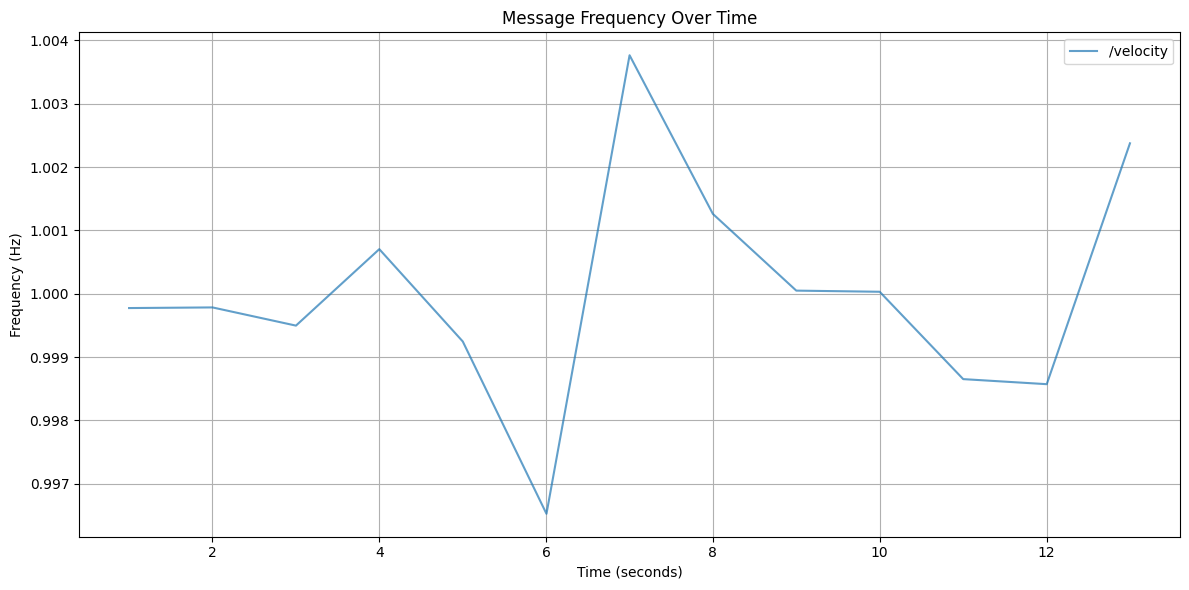

In [16]:
# Plot message frequencies for top topics
plot_message_frequency(topics_data)


In [17]:
# Optional: Plot timeline of when messages were received
def plot_message_timeline(topics_data):
    """
    Plot a timeline showing when messages were received on different topics.
    """
    # Get topics sorted by total message count
    topic_counts = [(topic, len(data['messages'])) for topic, data in topics_data.items()]
    topic_counts.sort(key=lambda x: x[1], reverse=True)

    # Take top N topics with the most messages
    top_n = min(10, len(topic_counts))
    selected_topics = [topic for topic, _ in topic_counts[:top_n]]

    plt.figure(figsize=(15, 8))

    # Plot each topic's timestamps
    for i, topic in enumerate(selected_topics):
        timestamps = topics_data[topic]['timestamps']
        plt.scatter(timestamps, [i] * len(timestamps), marker='|', s=10, label=topic)

    plt.yticks(range(len(selected_topics)), selected_topics)
    plt.xlabel("Time (seconds)")
    plt.title("Message Timeline by Topic")
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()


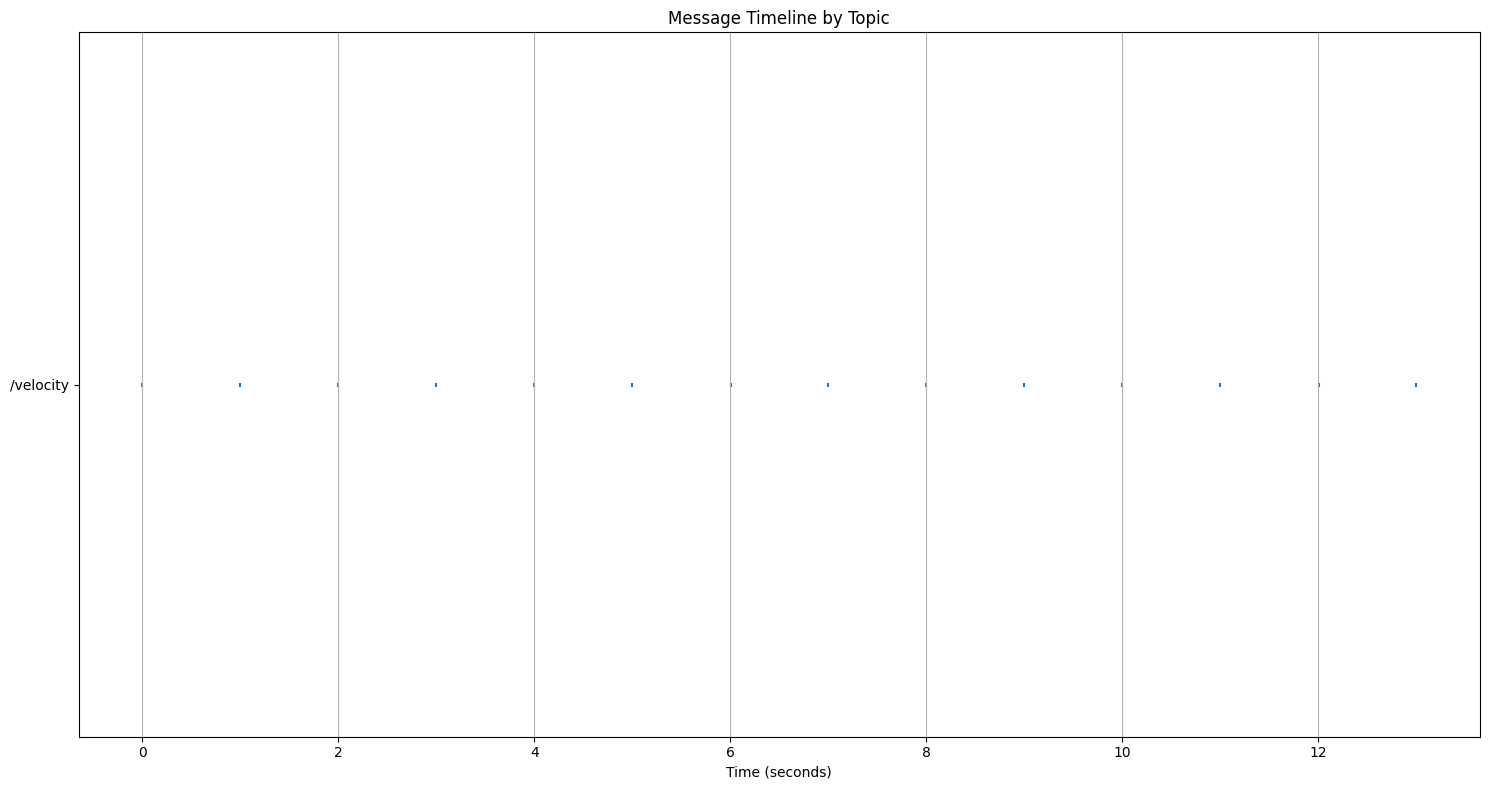

In [18]:
# Plot the message timeline
plot_message_timeline(topics_data)


In [19]:
# Optional: Create a 2D trajectory plot if position data is available
def plot_2d_trajectory(topics_data):
    """
    Attempt to create a 2D trajectory plot if position data is available.
    """
    # Look for topics that might contain position data
    position_topics = []
    for topic in topics_data.keys():
        if any(hint in topic.lower() for hint in ['pose', 'odom', 'position', 'path']):
            position_topics.append(topic)

    if not position_topics:
        print("No position-related topics found")
        return

    for topic in position_topics:
        print(f"Attempting to extract position data from: {topic}")

        # Try common field paths for position data
        position_paths = [
            'pose.position.x', 'pose.position.y',
            'position.x', 'position.y',
            'x', 'y'
        ]

        df = extract_numeric_data(topics_data[topic], position_paths)

        # Check if we have x and y data
        x_col = next((col for col in df.columns if col.endswith('.x') or col == 'x'), None)
        y_col = next((col for col in df.columns if col.endswith('.y') or col == 'y'), None)

        if x_col and y_col and not df[x_col].isnull().all() and not df[y_col].isnull().all():
            plt.figure(figsize=(10, 10))
            plt.plot(df[x_col], df[y_col])
            plt.title(f"2D Trajectory from {topic}")
            plt.xlabel("X Position")
            plt.ylabel("Y Position")
            plt.axis('equal')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            break
    else:
        print("Could not find suitable position data for trajectory plotting")


In [20]:
# Try to plot a 2D trajectory
plot_2d_trajectory(topics_data)


No position-related topics found
